# Analysis of Twitter the-algorithm source code with LangChain, GPT4 and Deep Lake
In this tutorial, we are going to use Langchain + Deep Lake with GPT4 to analyze the code base of the twitter algorithm. 

Define OpenAI embeddings, Deep Lake multi-modal vector store api and authenticate. For full documentation of Deep Lake please follow [docs](https://docs.activeloop.ai/) and [API reference](https://docs.deeplake.ai/en/latest/).

Authenticate into Deep Lake if you want to create your own dataset and publish it. You can get an API key from the [platform](https://app.activeloop.ai)

In [1]:
import re

In [ ]:
TRANSFORMERS_CACHE="/f/C/cache/huggingface/hub"

In [2]:
import os
import tqdm as notebook_tqdm
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import DeepLake

os.environ['TRANSFORMERS_CACHE'] = 'F:\C\cache\huggingface\hub'
os.environ['ACTIVELOOP_TOKEN'] = 'xxxxxxxxxx.xxxxxxxxxx.FeYGCK2Cc-xxxxxxxxxxxxxxx'

model_name = "sentence-transformers/multi-qa-mpnet-base-dot-v1"
embeddings = HuggingFaceEmbeddings(model_name=model_name)

Load all files inside the repository

In [3]:
from langchain.document_loaders import PyPDFLoader
import tiktoken

root_dir = '../dev/langchain/langchain'  # Declare root directory variable
docs = []  # Create empty list for documents

pdf_loader = PyPDFLoader('../sources-docs/Talks-with-Sri-Ramana-Maharshi--complete.pdf')  # Use PDFLoader to load and split the PDF file's content
docs.extend(pdf_loader.load()) # just load, don't split

In [29]:
import re
len(docs) # number of processed document pages
print(docs[40]) # returns 31Talks with Sri Ramana Maharshi\n(a) Is omniscience of God consis ....
print(type(docs[40])) # <class 'str'>
# Use regex to remove "31Talks with Sri Ramana Maharshi\n"
pg_40 = re.sub(r'\d{1,3}Talks with Sri Ramana Maharshi\\n', '', str(docs[40]))
print(pg_40)

page_content='31Talks with Sri Ramana Maharshi\n(a) Is omniscience of God consistent with ego’s freewill?\n(b) Is omnipotence of God consistent with ego’s freewill?\n(c) Are the natural laws consistent with God’s free-will?\nM.: Yes. Free-will is the present appearing to a limited faculty of \nsight and will. The same ego sees its past activity as falling into a \ncourse of ‘law’ or rules - its own free-will being one of the links \nin that course of law.\nOmnipotence and omniscience of God are then seen by the ego to \nhave acted through the appearance of his own free-will. So he comes \nto the conclusion that the ego must go by appearances. Natural laws \nare manifestations of God’s will and they have been laid down.\nD.: Is the study of science, psychology, physiology, philosophy, etc. \nhelpful for:-\n(1) this art of yoga-liberation.\n(2) the intuitive grasp of the unity of the Real?\nM.: Very little. Some knowledge is needed for yoga and it may be \nfound in books. But practical a

In [16]:
import tiktoken

tokenizer = tiktoken.get_encoding('cl100k_base')

# create the length function
def tiktoken_len(text):
    tokens = tokenizer.encode(
        text,
        disallowed_special=()
    )
    return len(tokens)

# Visualizing Token Length in Docs

Min: 0
Avg: 490
Max: 812


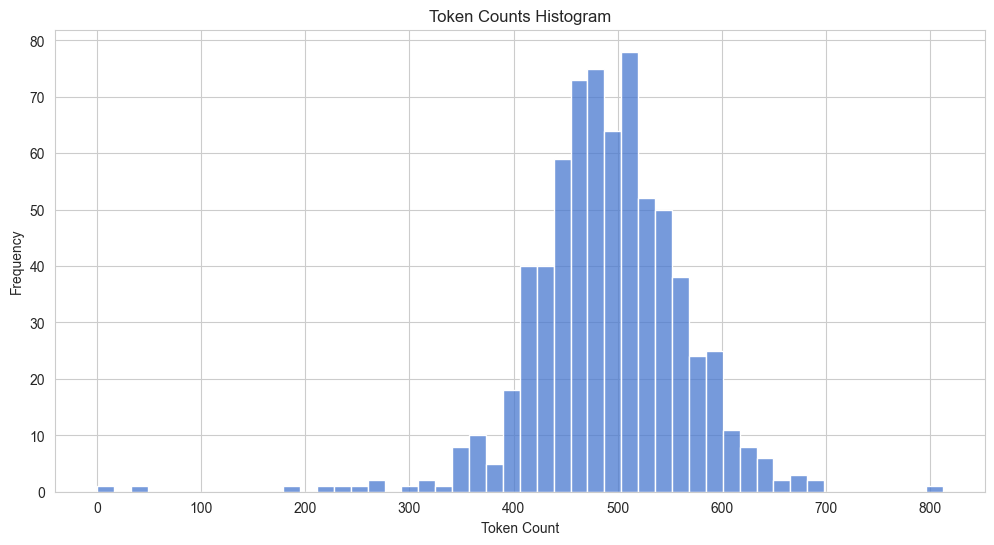

In [52]:
token_counts = [tiktoken_len(doc.page_content) for doc in docs]

print(f"""Min: {min(token_counts)}
Avg: {int(sum(token_counts) / len(token_counts))}
Max: {max(token_counts)}""")

import matplotlib.pyplot as plt
import seaborn as sns

# set style and color palette for the plot
sns.set_style("whitegrid")
sns.set_palette("muted")

# create histogram
plt.figure(figsize=(12, 6))
sns.histplot(token_counts, kde=False, bins=50)

# customize the plot info
plt.title("Token Counts Histogram")
plt.xlabel("Token Count")
plt.ylabel("Frequency")

plt.show()

Then, chunk the files

## New Chunking method

In [18]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=400,
    chunk_overlap=20,  # number of tokens overlap between chunks
    length_function=tiktoken_len,
    separators=['\n\n', '\n', ' ', '']
)

In [19]:
print(docs[25])

page_content='16Talks with Sri Ramana Maharshi\nD.: They say that there are many saints in Tibet who remain in solitude \nand are still very helpful to the world. How can it be?\nM.: It can be so. Realisation of the Self is the greatest help that can be \nrendered to humanity. Therefore, the saints are said to be helpful, \nthough they remain in forests. But it should not be forgotten that \nsolitude is not in forests only. It can be had even in towns, in the \nthick of worldly occupations.\nD.: It is not necessary that the saints should mix with people and be \nhelpful to them?\nM.: The Self alone is the Reality; the world and the rest of it are not. The \nrealised being does not see the world as different from himself.\nD.: Thus then, the saint’s realisation leads to the uplift of humanity \nwithout the latter being aware of it. Is it so?\nM.: Yes. The help is imperceptible but is still there. A saint helps the \nwhole of humanity, unknown to the latter.\nD.: Would it not be better i

In [36]:
import hashlib
m = hashlib.md5()  # this will convert URL into unique ID

from tqdm.auto import tqdm
from langchain.docstore.document import Document
documents = []

for doc in tqdm(docs):
    url = doc.metadata['source'].replace('../dev/langchain/langchain\\', 'https://github.com/hwchase17/langchain/tree/master/langchain/')
    m.update(url.encode('utf-8'))
    uid = m.hexdigest()[:12]
    chunks = text_splitter.split_text(doc.page_content)
    for i, chunk in enumerate(chunks):
        documents.append(
            Document(
                page_content = chunk
            )
        )
            # {'text': chunk})
        # documents.append({
        #     'id': f'{uid}-{i}',
        #     'text': chunk,
        #     'source': url
        # })
        # documents.extend(f"id={uid}-{i}")
        # documents.extend('text={chunk}')
        # documents.extend('source={url}')


  0%|          | 0/704 [00:00<?, ?it/s]

In [48]:
len(documents)
print(docs[25])

page_content='16Talks with Sri Ramana Maharshi\nD.: They say that there are many saints in Tibet who remain in solitude \nand are still very helpful to the world. How can it be?\nM.: It can be so. Realisation of the Self is the greatest help that can be \nrendered to humanity. Therefore, the saints are said to be helpful, \nthough they remain in forests. But it should not be forgotten that \nsolitude is not in forests only. It can be had even in towns, in the \nthick of worldly occupations.\nD.: It is not necessary that the saints should mix with people and be \nhelpful to them?\nM.: The Self alone is the Reality; the world and the rest of it are not. The \nrealised being does not see the world as different from himself.\nD.: Thus then, the saint’s realisation leads to the uplift of humanity \nwithout the latter being aware of it. Is it so?\nM.: Yes. The help is imperceptible but is still there. A saint helps the \nwhole of humanity, unknown to the latter.\nD.: Would it not be better i

page_content='"""Beta Feature: base interface for cache."""\nimport json\nfrom abc import ABC, abstractmethod\nfrom typing import Any, Callable, Dict, List, Optional, Tuple\n\nfrom sqlalchemy import Column, Integer, String, create_engine, select\nfrom sqlalchemy.engine.base import Engine\nfrom sqlalchemy.orm import Session\n\ntry:\n    from sqlalchemy.orm import declarative_base\nexcept ImportError:\n    from sqlalchemy.ext.declarative import declarative_base\n\nfrom langchain.schema import Generation\n\nRETURN_VAL_TYPE = List[Generation]\n\n\nclass BaseCache(ABC):\n    """Base interface for cache."""\n\n    @abstractmethod\n    def lookup(self, prompt: str, llm_string: str) -> Optional[RETURN_VAL_TYPE]:\n        """Look up based on prompt and llm_string."""\n\n    @abstractmethod\n    def update(self, prompt: str, llm_string: str, return_val: RETURN_VAL_TYPE) -> None:\n        """Update cache based on prompt and llm_string."""\n\n\nclass InMemoryCache(BaseCache):\n    """Cache that st

Execute the indexing. This will take about ~4 mins to compute embeddings and upload to Activeloop. You can then publish the dataset to be public.

# Vector Storage

In [56]:
database_name = "ramana_talks2"

content_source = documents
# content_source = text   # Old chunking method

## Local

In [55]:
import deeplake
db = DeepLake.from_documents(content_source, embeddings, dataset_path=f"mem://{database_name}")

mem://ramana_talks loaded successfully.


Evaluating ingest: 0%|          | 0/2 [00:00<?

KeyboardInterrupt: 

In [51]:
db = DeepLake(dataset_path=f"mem://{database_name}", read_only=True, embedding_function=embeddings)

mem://ramana_talks loaded successfully.


## Remote storage

Uses Activeloop API

In [ ]:
os.environ['ACTIVELOOP_TOKEN'] = 'xxxxxxxxxxxxx.xxxx.xxxxxxxxxxxxx'
db = DeepLake.from_documents(content_source, embeddings, dataset_path=f"hub://deadbranches/{database_name}")

In [ ]:
db = DeepLake(dataset_path=f"hub://deadbranches/{database_name}", read_only=True, embedding_function=embeddings)

## Visualize data

### 2. Question Answering on Twitter algorithm codebase
First load the dataset, construct the retriever, then construct the Conversational Chain

In [46]:

retriever = db.as_retriever()
retriever.search_kwargs['distance_metric'] = 'dot'
retriever.search_kwargs['fetch_k'] = 100
retriever.search_kwargs['maximal_marginal_relevance'] = True
retriever.search_kwargs['k'] = 20

In [54]:
import json
from langchain.schema import Document

results = db.similarity_search('What did the president say about Ketanji Brown Jackson?', distance_metric='dot', k=4)

print("class:", type(results).__name__)
print("[")
for result in results:
    print("    {")
    print(f"        'page_content': {json.dumps(result.page_content)},")
    print(f"        'metadata': {json.dumps(result.metadata)},")
    print("    },")
print("]")

ValueError: shapes (768,) and (0,) not aligned: 768 (dim 0) != 0 (dim 0)

In [53]:
query = """
How should I meditate?
"""
results = db.similarity_search(query, distance_metric='dot', k=4)


# print("class:", type(results).__name__)
for result in results:
    print(f"Source:  {result.metadata['source']} ")
    print("\nContent:  ")
    page_content = json.dumps(result.page_content).replace('\\n', '\n').replace('\\"', '"')
    print(page_content)
    print("\n\n")

ValueError: shapes (768,) and (0,) not aligned: 768 (dim 0) != 0 (dim 0)

You can also specify user defined functions using [Deep Lake filters](https://docs.deeplake.ai/en/latest/deeplake.core.dataset.html#deeplake.core.dataset.Dataset.filter)

In [15]:
def filter(x):
    # filter based on source code
    # if 'com.google' in x['text'].data()['value']:
    #     return False
    
    # filter based on path e.g. extension
    metadata =  x['metadata'].data()['value']
    return 'scala' in metadata['source'] or 'py' in metadata['source']

### turn on below for custom filtering
# retriever.search_kwargs['filter'] = filter

In [23]:
os.environ['OPENAI_API_KEY'] = 'sk-xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx'

from langchain.chat_models import ChatOpenAI
from langchain.chains import ConversationalRetrievalChain

import logging

logging.basicConfig(level=logging.DEBUG)

#model = ChatOpenAI(model='gpt-4') # 'gpt-3.5-turbo',
model = ChatOpenAI(model='gpt-3.5-turbo') # 'gpt-3.5-turbo',
qa = ConversationalRetrievalChain.from_llm(model,retriever=retriever)

In [25]:
questions = [
    "How do I load a 4bit quantized LLaMA model into langchain for inference tasks? The model was quantized using GPTQ, and has a group size of 128?",
] 
chat_history = []

# for question in questions:  
#     result = qa({"question": question, "chat_history": chat_history})
#     print(result)

for question in questions:  
    result = qa({"question": question, "chat_history": chat_history})
    chat_history.append((question, result['answer']))
    print(f"-> **Question**: {question} \n")
    print(f"**Answer**: {result['answer']} \n")


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:openai:message='Request to OpenAI API' method=post path=https://api.openai.com/v1/chat/completions
DEBUG:openai:api_version=None data='{"messages": [{"role": "system", "content": "Use the following pieces of context to answer the users question. \\nIf you don\'t know the answer, just say that you don\'t know, don\'t try to make up an answer.\\n----------------\\nHourly Parameter Definition\\nThe parameter &hourly= accepts the following values. Most weather variables are given as an instantaneous value for the indicated hour. Some variables like precipitation are calculated from the preceding hour as an average or sum.\\n\\nHourly Parameter Definition\\nThe parameter &hourly= accepts the following values. Most weather variables are given as an instantaneous value for the indicated hour. Some variables like precipitation are calculated from the preceding hour as an average or sum.\\n\\ndef _default_scripting_text_mapping(\\n    dim: int,\\n    vector_field: str = \\"vector_field\\"

-> **Question**: How do I load a 4bit quantized LLaMA model into langchain for inference tasks? The model was quantized using GPTQ, and has a group size of 128? 

**Answer**: I'm sorry, but I am not familiar with the Langchain framework or with the GPTQ quantization method. Without more information, I cannot provide an accurate answer to your question. Can you provide more details or context about what you are trying to do? 

